# 🏏 IPL Win Probability Predictor

This notebook develops a machine learning model to predict the probability of a team winning an IPL match based on real-time match features like runs, wickets, overs remaining, and more. It includes data cleaning, feature engineering, model training, and simulation logic used in the Streamlit app.


## 📚 Importing Required Libraries

We begin by importing essential libraries for data handling, visualization, and model building.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Loading the Datasets 📊
We'll load two key datasets: matches.csv for match-level information and deliveries.csv for ball-by-ball details. 📄

In [2]:
match = pd.read_csv('matches.csv')
delivery = pd.read_csv('deliveries.csv')

In [3]:
#display first few rows
match.head()

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,IPL-2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,IPL-2017,Rajkot,07-04-2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,IPL-2017,Indore,08-04-2017,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


In [4]:
match.shape

(756, 18)

In [151]:
#display first few rows
delivery.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,NaN,NaN,NaN


## 🧹 Data Cleaning

Here, we filter out unnecessary matches and focus on valid second innings data for prediction modeling.


#### Calculating First Inning Total Scores 🏏
We need the total runs scored in the first inning of each match. This will be crucial for our prediction model! 💯

In [6]:
total_score_df = delivery.groupby(['match_id','inning']).sum()['total_runs'].reset_index()

In [7]:
total_score_df = total_score_df[total_score_df['inning'] == 1]

In [8]:
total_score_df

,match_id,inning,total_runs
0,1,1,207
2,2,1,184
4,3,1,183
6,4,1,163
8,5,1,157
...,...,...,...
1518,11347,1,143
1520,11412,1,136
1522,11413,1,171
1524,11414,1,155


#### Merging DataFrames 🤝
We'll merge the match dataframe with our total_score_df to have match details and first inning scores together. 🔄

In [9]:
match_df = match.merge(total_score_df[['match_id','total_runs']],left_on='id',right_on='match_id')

In [10]:
match_df

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,match_id,total_runs
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,207
1,2,IPL-2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN,2,184
2,3,IPL-2017,Rajkot,07-04-2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN,3,183
3,4,IPL-2017,Indore,08-04-2017,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN,4,163
4,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN,5,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,11347,IPL-2019,Mumbai,05-05-2019,Kolkata Knight Riders,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,9,HH Pandya,Wankhede Stadium,Nanda Kishore,O Nandan,S Ravi,11347,143
752,11412,IPL-2019,Chennai,07-05-2019,Chennai Super Kings,Mumbai Indians,Chennai Super Kings,bat,normal,0,Mumbai Indians,0,6,AS Yadav,M. A. Chidambaram Stadium,Nigel Llong,Nitin Menon,Ian Gould,11412,136
753,11413,IPL-2019,Visakhapatnam,08-05-2019,Sunrisers Hyderabad,Delhi Capitals,Delhi Capitals,field,normal,0,Delhi Capitals,0,2,RR Pant,ACA-VDCA Stadium,NaN,NaN,NaN,11413,171
754,11414,IPL-2019,Visakhapatnam,10-05-2019,Delhi Capitals,Chennai Super Kings,Chennai Super Kings,field,normal,0,Chennai Super Kings,0,6,F du Plessis,ACA-VDCA Stadium,Sundaram Ravi,Bruce Oxenford,Chettithody Shamshuddin,11414,155


#### Standardizing Team Names 🧼
To ensure consistency, we'll standardize some team names. For example, 'Delhi Daredevils' will become 'Delhi Capitals'. ✍️

In [11]:
match_df['team1'].unique()

array(['Sunrisers Hyderabad', 'Mumbai Indians', 'Gujarat Lions',
       'Rising Pune Supergiant', 'Royal Challengers Bangalore',
       'Kolkata Knight Riders', 'Delhi Daredevils', 'Kings XI Punjab',
       'Chennai Super Kings', 'Rajasthan Royals', 'Deccan Chargers',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Rising Pune Supergiants',
       'Delhi Capitals'], dtype=object)

In [12]:
teams = [
    'Sunrisers Hyderabad',
    'Mumbai Indians',
    'Royal Challengers Bangalore',
    'Kolkata Knight Riders',
    'Kings XI Punjab',
    'Chennai Super Kings',
    'Rajasthan Royals',
    'Delhi Capitals'
]

In [13]:
match_df['team1'] = match_df['team1'].str.replace('Delhi Daredevils','Delhi Capitals')
match_df['team2'] = match_df['team2'].str.replace('Delhi Daredevils','Delhi Capitals')

match_df['team1'] = match_df['team1'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
match_df['team2'] = match_df['team2'].str.replace('Deccan Chargers','Sunrisers Hyderabad')

#### Filtering for Relevant Teams 🧹
We'll filter our match data to only include matches between the teams we defined. This cleans up our dataset for modeling. 🧼

In [14]:
match_df = match_df[match_df['team1'].isin(teams)]
match_df = match_df[match_df['team2'].isin(teams)]

In [15]:
match_df.shape

(641, 20)

#### Removing D/L Applied Matches 🌧️
Matches where the DLS method was applied can skew results, so we'll remove them. 🙅‍♀️

In [16]:
match_df = match_df[match_df['dl_applied'] == 0]

In [17]:
match_df = match_df[['match_id','city','winner','total_runs']]  # selecting key columns

#### Merging with Delivery Data 🤝
Now, we'll merge the filtered match_df with the delivery dataframe to get all the ball-by-ball details along with match outcomes. 🔄

In [18]:
delivery_df = match_df.merge(delivery,on='match_id')

#### Focusing on Second Inning Deliveries 🎯
Our prediction model will focus on the second inning, as we predict the target chase. So, we filter the delivery_df for only inning 2. 🎯

In [19]:
delivery_df = delivery_df[delivery_df['inning'] == 2]

In [20]:
delivery_df

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,0,0,0,0,1,0,1,NaN,NaN,NaN
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,0,0,0,NaN,NaN,NaN
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,0,0,0,NaN,NaN,NaN
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,0,0,0,0,2,0,2,NaN,NaN,NaN
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,0,0,0,0,4,0,4,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149573,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,2,RA Jadeja,...,0,0,0,0,1,0,1,NaN,NaN,NaN
149574,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,3,SR Watson,...,0,0,0,0,2,0,2,NaN,NaN,NaN
149575,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,4,SR Watson,...,0,0,0,0,1,0,1,SR Watson,run out,KH Pandya
149576,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,5,SN Thakur,...,0,0,0,0,2,0,2,NaN,NaN,NaN


## ⚙️ Feature Engineering

We construct match-contextual features such as:
- Runs left
- Balls left
- Wickets in hand
- Current and required run rate

These features are crucial for determining win probability.


#### Calculating Current Score, Runs Left , Balls Left and Wickets Left 📊

In [39]:
delivery_df['current_score'] = delivery_df.groupby('match_id')['total_runs_y'].cumsum()

In [41]:
delivery_df['runs_left'] = delivery_df['total_runs_x'] - delivery_df['current_score']

In [43]:
delivery_df['balls_left'] = 126 - (delivery_df['over']*6 + delivery_df['ball'])

In [45]:
delivery_df

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,penalty_runs,batsman_runs,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder,current_score,runs_left,balls_left
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,0,1,0,1,NaN,NaN,NaN,1,206,119
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,NaN,NaN,NaN,1,206,118
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,NaN,NaN,NaN,1,206,117
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,0,2,0,2,NaN,NaN,NaN,3,204,116
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,0,4,0,4,NaN,NaN,NaN,7,200,115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149573,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,2,RA Jadeja,...,0,1,0,1,NaN,NaN,NaN,152,0,4
149574,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,3,SR Watson,...,0,2,0,2,NaN,NaN,NaN,154,-2,3
149575,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,4,SR Watson,...,0,1,0,1,SR Watson,run out,KH Pandya,155,-3,2
149576,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,5,SN Thakur,...,0,2,0,2,NaN,NaN,NaN,157,-5,1


In [68]:
#Calculating wickets left

delivery_df['player_dismissed'] = delivery_df['player_dismissed'].fillna("0")
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].apply(lambda x: "0" if x == "0" else "1")
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].astype('int')
cumulative_wickets = delivery_df.groupby('match_id')['player_dismissed'].cumsum()
delivery_df['wickets'] = 10 - cumulative_wickets
delivery_df.head()

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,player_dismissed,dismissal_kind,fielder,current_score,runs_left,balls_left,crr,rrr,result,wickets
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,1,NaN,NaN,1,206,119,6.0,10.386555,0,9
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,1,NaN,NaN,1,206,118,3.0,10.474576,0,8
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,1,NaN,NaN,1,206,117,2.0,10.564103,0,7
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,1,NaN,NaN,3,204,116,4.5,10.551724,0,6
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,1,NaN,NaN,7,200,115,8.4,10.434783,0,5


In [70]:
delivery_df.head()

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,player_dismissed,dismissal_kind,fielder,current_score,runs_left,balls_left,crr,rrr,result,wickets
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,1,NaN,NaN,1,206,119,6.0,10.386555,0,9
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,1,NaN,NaN,1,206,118,3.0,10.474576,0,8
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,1,NaN,NaN,1,206,117,2.0,10.564103,0,7
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,1,NaN,NaN,3,204,116,4.5,10.551724,0,6
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,1,NaN,NaN,7,200,115,8.4,10.434783,0,5


In [72]:
# crr = runs/overs
# Calculating current run rate

delivery_df['crr'] = (delivery_df['current_score']*6)/(120 - delivery_df['balls_left'])   

In [74]:
# Calculating required run rate

delivery_df['rrr'] = (delivery_df['runs_left']*6)/delivery_df['balls_left']

#### Match Result (Win/Loss) 🏆
We'll create a result column to indicate whether the chasing team won (1) or lost (0). This is our target variable! ✅❌

In [76]:
def result(row):
    return 1 if row['batting_team'] == row['winner'] else 0

In [78]:
delivery_df['result'] = delivery_df.apply(result,axis=1)

In [79]:
final_df = delivery_df[['batting_team','bowling_team','city','runs_left','balls_left','wickets','total_runs_x','crr','rrr','result']]

#### Shuffling the Data 🔀
It's good practice to shuffle the data to prevent any order-related biases during training. 🎲

In [82]:
final_df = final_df.sample(final_df.shape[0])

In [84]:
final_df.sample()

,batting_team,bowling_team,city,runs_left,balls_left,wickets,total_runs_x,crr,rrr,result
137605,Delhi Capitals,Kolkata Knight Riders,Delhi,140,76,-35,193,7.227273,11.052632,1


In [86]:
final_df.dropna(inplace=True) # dropping null values

#### Removing Rows with Zero Balls Left ⚾
This is done to prevent errors (like division by zero) when calculating run rates later, ensuring our model works smoothly.

In [139]:
final_df = final_df[final_df['balls_left'] != 0]

#### Preview of Final Data 🚀
Let's check the first few rows of our prepared dataframe before splitting into training and testing sets. 🧐

In [141]:
final_df.head() 

,batting_team,bowling_team,city,runs_left,balls_left,wickets,total_runs_x,crr,rrr,result
9837,Chennai Super Kings,Kolkata Knight Riders,Chennai,70,60,-54,147,7.700000,7.000000,1
70695,Delhi Daredevils,Kings XI Punjab,Dharamsala,134,115,5,141,8.400000,6.991304,1
138113,Rajasthan Royals,Chennai Super Kings,Chennai,118,73,-40,182,8.170213,9.698630,0
90105,Kolkata Knight Riders,Kings XI Punjab,Abu Dhabi,38,18,-95,132,5.529412,12.666667,0
17283,Rajasthan Royals,Kolkata Knight Riders,Kolkata,62,51,-60,147,7.391304,7.294118,1


## Model Training! 🧠

#### Splitting Data for Training and Testing 🏋️‍♂️🧪
We'll split our data into features (X) and target (y), then further into training and testing sets. This is crucial for evaluating our model's performance. 🎯


In [90]:
X = final_df.iloc[:,:-1]
y = final_df.iloc[:,-1]
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [91]:
X_train

,batting_team,bowling_team,city,runs_left,balls_left,wickets,total_runs_x,crr,rrr
100167,Chennai Super Kings,Mumbai Indians,Mumbai,95,68,-45,173,9.000000,8.382353
83750,Kings XI Punjab,Delhi Daredevils,Delhi,56,68,-43,120,7.384615,4.941176
84762,Kings XI Punjab,Royal Challengers Bangalore,Chandigarh,52,29,-83,190,9.098901,10.758621
112013,Royal Challengers Bangalore,Kings XI Punjab,Chandigarh,22,59,-53,106,8.262295,2.237288
137095,Sunrisers Hyderabad,Rajasthan Royals,Hyderabad,167,98,-13,203,9.818182,10.224490
...,...,...,...,...,...,...,...,...,...
130179,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,67,45,-67,155,7.040000,8.933333
87433,Rajasthan Royals,Sunrisers Hyderabad,Abu Dhabi,129,116,6,133,6.000000,6.672414
47124,Royal Challengers Bangalore,Mumbai Indians,Mumbai,43,8,-109,184,7.553571,32.250000
16814,Deccan Chargers,Mumbai Indians,Hyderabad,93,40,-73,178,6.375000,13.950000


#### Column Transformation using OneHotEncoder and StandardScaler ⚙️
We'll use a ColumnTransformer to apply OneHotEncoder to categorical features (teams, city). This prepares our data for the machine learning model. 🤖

In [92]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

trf = ColumnTransformer([
    ('trf',OneHotEncoder(sparse=False,drop='first'),['batting_team','bowling_team','city'])
]
,remainder='passthrough')

#### Building the Pipeline 🛠️
We'll create a pipeline that first applies our transformations (trf) and then trains a LogisticRegression model. This streamlines our workflow! 🚂

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

In [94]:
pipe = Pipeline(steps=[
    ('step1',trf),
    ('step2',LogisticRegression(solver='liblinear'))
])

#### Training the Model! 🧠
Let's train our LogisticRegression model using the transformed training data. This is where the magic happens! ✨

In [95]:
pipe.fit(X_train,y_train)

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trf',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('step2', LogisticRegression(solver='liblinear'))])

## Model Prediction and Accuracy 🔮
Now, let's make predictions on the test set and evaluate our model's accuracy. How well did it learn? 🤔


In [96]:
y_pred = pipe.predict(X_test)

In [98]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.7918564720723246

#### Prediction Probability 📈
Let's look at the probabilities of winning/losing for the test set. This gives us more insight than just a binary prediction. 📊

In [101]:
pipe.predict_proba(X_test)[10]

array([0.7106457, 0.2893543])

#### Match Summary Function 📝
Prints quick match details

In [104]:
def match_summary(row):
    print("Batting Team-" + row['batting_team'] + " | Bowling Team-" + row['bowling_team'] + " | Target- " + str(row['total_runs_x']))
    

#### Match Progression Function 📈
Calculates and returns match progress per over, including win/loss probabilities. 📊

In [110]:
def match_progression(x_df,match_id,pipe):
    match = x_df[x_df['match_id'] == match_id]
    match = match[(match['ball'] == 6)]
    temp_df = match[['batting_team','bowling_team','city','runs_left','balls_left','wickets','total_runs_x','crr','rrr']].dropna()
    temp_df = temp_df[temp_df['balls_left'] != 0]
    result = pipe.predict_proba(temp_df)
    temp_df['lose'] = np.round(result.T[0]*100,1)
    temp_df['win'] = np.round(result.T[1]*100,1)
    temp_df['end_of_over'] = range(1,temp_df.shape[0]+1)
    
    target = temp_df['total_runs_x'].values[0]
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]
    runs.insert(0,target)
    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)
    wickets = list(temp_df['wickets'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0,10)
    wickets.append(0)
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[0:temp_df.shape[0]]
    
    print("Target-",target)
    temp_df = temp_df[['end_of_over','runs_after_over','wickets_in_over','lose','win']]
    return temp_df,target
    

#### Run Match Simulation 🏏
Runs the match_progression for a specific match (ID 74) and shows the results. 🎲

In [112]:
temp_df,target = match_progression(delivery_df,74,pipe)
temp_df

Target- 178


,end_of_over,runs_after_over,wickets_in_over,lose,win
10459,1,4,6,62.3,37.7
10467,2,8,8,62.0,38.0
10473,3,1,6,74.6,25.4
10479,4,7,6,75.4,24.6
10485,5,12,6,67.7,32.3
10491,6,13,6,57.4,42.6
10497,7,9,6,54.9,45.1
10505,8,15,8,42.0,58.0
10511,9,7,6,43.8,56.2
10518,10,17,7,27.4,72.6


#### Plotting Match Progress 📊📈
Creates a plot showing win/loss chances, runs per over, and wickets fallen during a match. 🏟️

Text(0.5, 1.0, 'Target-178')

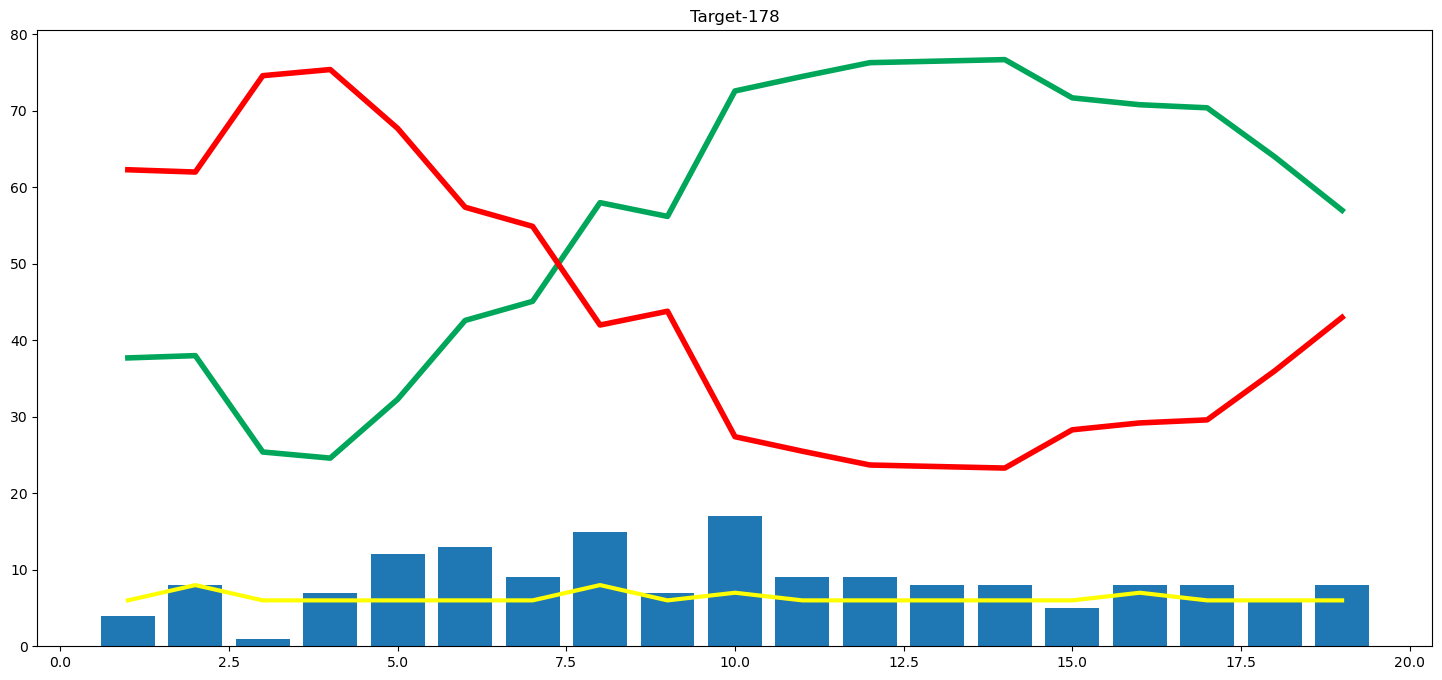

In [114]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,8))
plt.plot(temp_df['end_of_over'],temp_df['wickets_in_over'],color='yellow',linewidth=3)
plt.plot(temp_df['end_of_over'],temp_df['win'],color='#00a65a',linewidth=4)
plt.plot(temp_df['end_of_over'],temp_df['lose'],color='red',linewidth=4)
plt.bar(temp_df['end_of_over'],temp_df['runs_after_over'])
plt.title('Target-' + str(target))

In [115]:
teams # Display the list of teams

['Sunrisers Hyderabad',
 'Mumbai Indians',
 'Royal Challengers Bangalore',
 'Kolkata Knight Riders',
 'Kings XI Punjab',
 'Chennai Super Kings',
 'Rajasthan Royals',
 'Delhi Capitals']

In [116]:
delivery_df['city'].unique() # Display unique cities where matches were played

array(['Hyderabad', 'Bangalore', 'Mumbai', 'Indore', 'Kolkata', 'Delhi',
       'Chandigarh', 'Jaipur', 'Chennai', 'Cape Town', 'Port Elizabeth',
       'Durban', 'Centurion', 'East London', 'Johannesburg', 'Kimberley',
       'Bloemfontein', 'Ahmedabad', 'Cuttack', 'Nagpur', 'Dharamsala',
       'Visakhapatnam', 'Pune', 'Raipur', 'Ranchi', 'Abu Dhabi',
       'Sharjah', nan, 'Mohali', 'Bengaluru'], dtype=object)

## Saving the Model 💾
Finally, we'll save our trained pipeline using pickle so we can reuse it later without retraining! 🚀

In [119]:
import pickle
pickle.dump(pipe,open('pipe.pkl','wb'))